In [1]:
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

In [2]:
class Arm:
    def __init__(self, p, q):
        self.p = p
        self.q = q
        self.success = 0
        self.proxy_success = 0
        self.fail = 0

    def play(self):
        proxy = random.binomial(n=1, p=self.p)
        result = proxy * random.binomial(n=1, p=self.q)
        return proxy, result

    def update(self, proxy, result):
        if result == 1:
            self.success += 1
        elif proxy == 1:
            self.proxy_success += 1
        else:
            self.fail += 1

In [3]:
def thompson_sampling(arms, T, alpha1=1, beta1=1):
    optimal_value = max(arm.p * arm.q for arm in arms)
    regret_history = []
    regret = 0

    for _ in range(T):
        samples = [random.beta(arm.success+alpha1, arm.proxy_success+arm.fail+beta1) for arm in arms]
        max_arm = np.argmax(samples)
        proxy, result = arms[max_arm].play()

        regret += (optimal_value - arms[max_arm].p * arms[max_arm].q)
        regret_history.append(regret)

        arms[max_arm].update(proxy, result)

    return regret_history

def thompson_sampling_with_proxy(arms, T, alpha1=1, beta1=1, alpha2=1, beta2=1):
    optimal_value = max(arm.p * arm.q for arm in arms)
    regret_history = []
    regret = 0

    for _ in range(T):
        samples = [random.beta(arm.success+arm.proxy_success+alpha1, arm.fail+beta1) * random.beta(arm.success+alpha2, arm.proxy_success+beta2) for arm in arms]
        max_arm = np.argmax(samples)
        proxy, result = arms[max_arm].play()

        regret += optimal_value - arms[max_arm].p * arms[max_arm].q
        regret_history.append(regret)

        arms[max_arm].update(proxy, result)

    return regret_history

def regret_lower_limit(arms, T):
    optimal_value = max(arm.p * arm.q for arm in arms)

    coef = 0
    for arm in arms:
        if arm.p * arm.q == optimal_value:
            continue
        difference = optimal_value - arm.p * arm.q
        kl = arm.p * arm.q * np.log(arm.p * arm.q / optimal_value) + (1 - arm.p * arm.q) * np.log((1 - arm.p * arm.q) / (1 - optimal_value))
        coef += difference / kl

    time_steps = np.arange(1, T+1)
    log_regret = coef * np.log(time_steps)

    return  log_regret

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


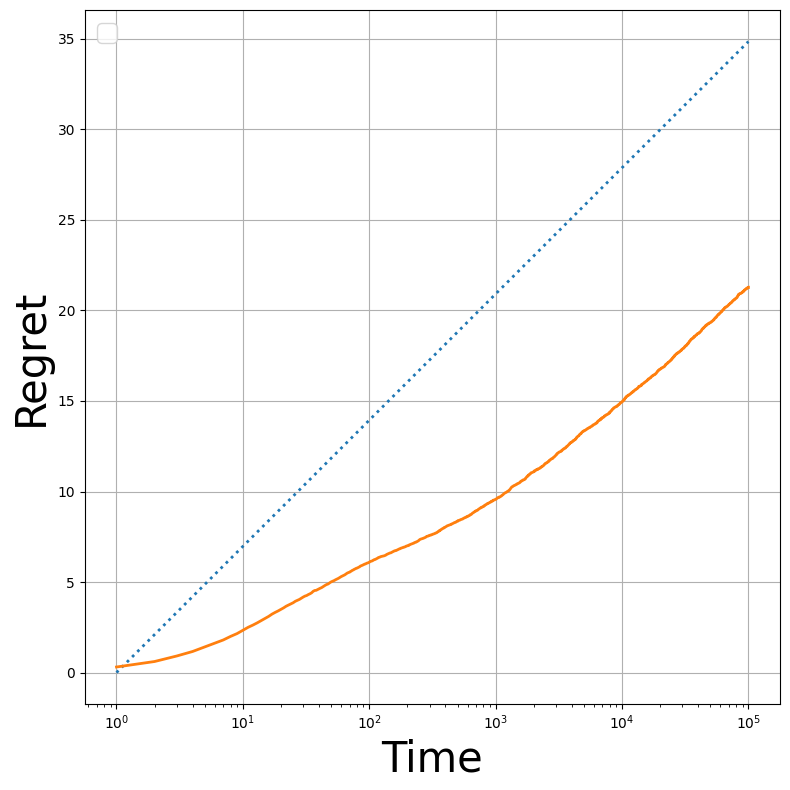

In [8]:
T = 100000
N = 100

random.seed(42)

pq_values_fixed = [
    [0.9, 0.8],
    [0.7, 0.6],
    [0.5, 0.4],
    [0.2, 0.1],
]

def calculate_regret(algorithm, *args):
    regret_histories = []
    for _ in range(N):
        arms = [Arm(p, q) for p, q in pq_values_fixed]
        regret_history = algorithm(arms, T, *args)
        regret_histories.append(regret_history)

    return np.mean(regret_histories, axis=0)

regret_ts_proxy= calculate_regret(thompson_sampling_with_proxy, 1, 1, 1, 1)
regret_ll = calculate_regret(regret_lower_limit)
time_steps = np.arange(1, T+1)

plt.figure(figsize=(8, 8))
plt.plot(time_steps, regret_ll, linestyle=':', linewidth='2')
plt.plot(time_steps, regret_ts_proxy, linestyle='-', linewidth='2')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.legend(fontsize=18)
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


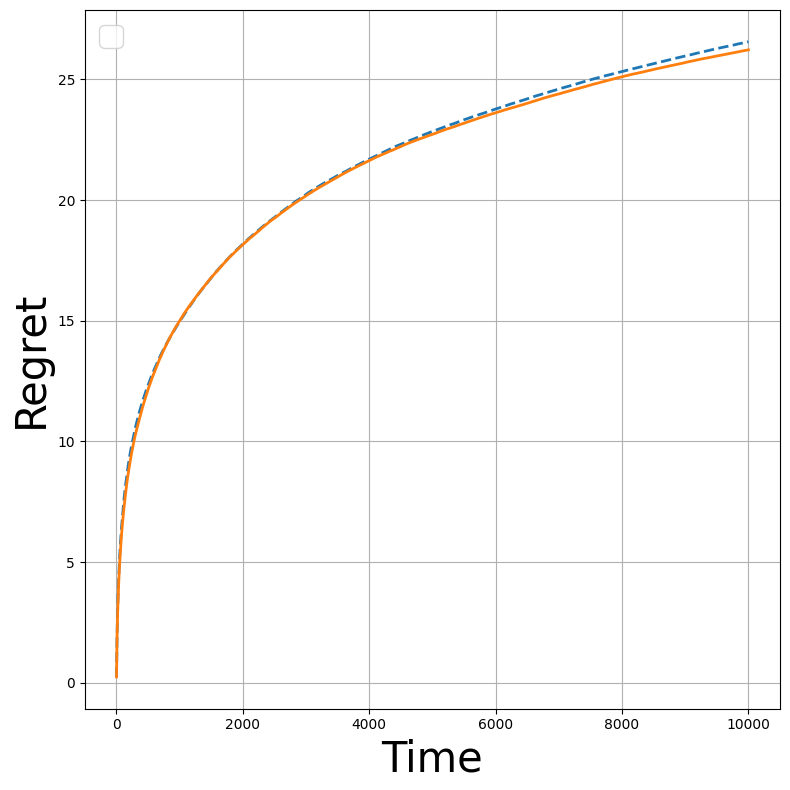

In [5]:
T = 10000
N = 1000

random.seed(42)

def calculate_regret(algorithm, *args):
    regret_histories = []
    for _ in range(N):
        pq_values = [[random.uniform(0, 1), random.uniform(0, 1)] for _ in range(4)]
        arms = [Arm(p, q) for p, q in pq_values]
        regret_history = algorithm(arms, T, *args)
        regret_histories.append(regret_history)

    return np.mean(regret_histories, axis=0)

regret_ts = calculate_regret(thompson_sampling, 1, 3)
regret_ts_proxy= calculate_regret(thompson_sampling_with_proxy, 1, 1, 1, 1)
time_steps = np.arange(1, T+1)

plt.figure(figsize=(8, 8))
plt.plot(time_steps, regret_ts, linestyle='--', linewidth='2')
plt.plot(time_steps, regret_ts_proxy, linestyle='-', linewidth='2')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.legend(fontsize=21)
plt.grid(True)
# plt.xscale('log')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


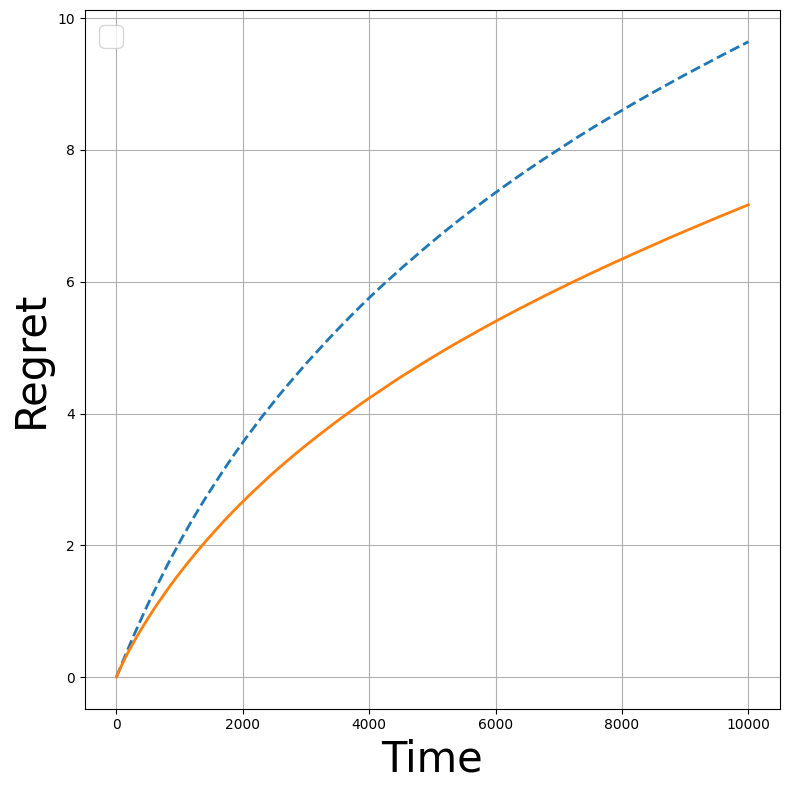

In [6]:
T = 10000
N = 1000

np.random.seed(42)

def calculate_regret(algorithm, *args):
    regret_histories = []
    for _ in range(N):
        pq_values = [[np.random.uniform(0.01, 0.1), np.random.uniform(0.01, 0.1)] for _ in range(4)]
        arms = [Arm(p, q) for p, q in pq_values]
        regret_history = algorithm(arms, T, *args)
        regret_histories.append(regret_history)

    return np.mean(regret_histories, axis=0)

regret_ts = calculate_regret(thompson_sampling, 2, 798)
regret_ts_proxy = calculate_regret(thompson_sampling_with_proxy, 2, 38, 2, 38)
time_steps = np.arange(1, T+1)

plt.figure(figsize=(8, 8))
plt.plot(time_steps, regret_ts, linestyle='--', linewidth='2')
plt.plot(time_steps, regret_ts_proxy, linestyle='-', linewidth='2')
plt.xlabel('Time', fontsize=30)
plt.ylabel('Regret', fontsize=30)
plt.legend(fontsize=21)
plt.grid(True)
# plt.xscale('log')
plt.tight_layout()
plt.show()